<a href="https://colab.research.google.com/github/Madelinelai/SideProject/blob/main/SP_house_price_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **第一個模型與成效評估**

In [ ]:
# 套件安裝 (避免未來 Colab 預設使用新版本 Python 套件造成程式無法執行)
!pip install arrow==0.15.5
!pip install PyDrive==1.3.1
!pip install lightgbm==2.3.1

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 1.2MB 2.9MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import arrow
import glob
import graphviz 
import numpy as np
import os
import pandas as pd
import re

from lightgbm import LGBMRegressor
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

# 固定 random seed，確保每次亂數結果都一樣
np.random.seed(551335114)

In [ ]:
# 下載房價資料

if not os.path.exists('house_price.zip'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1QOaz8sqVyZzvjikzUzUfpcEiyBKi9-dE'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('house_price.zip')
if not os.path.exists('taiwan-address-data.zip'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '1JFBIaoq6VyV5P4pgE-ug3lljgjI8Olht'
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile('taiwan-address-data.zip')
!unzip house_price.zip
!unzip -qq taiwan-address-data.zip
!ls taiwan-address-data

Archive:  house_price.zip
   creating: house_price/
  inflating: house_price/107S3_A_lvr_land_A.csv  
  inflating: house_price/107S4_A_lvr_land_A.csv  
  inflating: house_price/108S1_A_lvr_land_A.csv  
  inflating: house_price/108S2_A_lvr_land_A.csv  
  inflating: house_price/108S3_A_lvr_land_A.csv  
  inflating: house_price/108S4_A_lvr_land_A.csv  
  inflating: house_price/109S1_A_lvr_land_A.csv  
address.html  area_1984.csv  area_2014.csv    README.md  roads
address.js    area_2010.csv  area_custom.csv  road.csv


In [ ]:
# train 10707 - 10806
# validation 10807 - 10809
# test 10810 - 10812
# 讀取 training 期間的資料
label = 'the unit price (NTD / square meter)'
df_train = []
df_val = None
df_test = []
for path in sorted(glob.glob('house_price/*.csv')):
    if '108S3' not in path and '108S4' not in path and '109S1' not in path:
        df_train.append(pd.read_csv(path, skiprows=1))
    elif '108S3' in path:
        df_val = pd.read_csv(path, skiprows=1)
    else:
        df_test.append(pd.read_csv(path, skiprows=1))
df_train = pd.concat(df_train)
df_test = pd.concat(df_test)

# 刪掉不要的交易時間
df_train = df_train.loc[df_train['transaction year month and day'].map(lambda x: 1070701 <= x < 1080701 if x else False)]
df_val = df_val.loc[df_val['transaction year month and day'].map(lambda x: 1080701 <= x < 1081001 if x else False)]
df_test = df_test.loc[df_test['transaction year month and day'].map(lambda x: 1081001 <= x < 1090101 if x else False)]


In [ ]:
DIR_ADDR = 'taiwan-address-data/'

pattern_section = re.compile('\d+段')
pattern_lane = re.compile('\d+巷')
pattern_alley = re.compile('\d+弄')
pattern_number = re.compile('\d+號')

def get_area2id():
    area2id = dict()
    for file in glob.iglob(os.path.join(DIR_ADDR, 'area_*.csv')):
        df = pd.read_csv(file, index_col='name')
        for k, v in df.to_dict()['dgbas_id'].items():
            v = str(v)
            if k not in area2id:
                cid, tid, vid = '', '', ''
                if len(v) == 11:
                    vid = v
                    tid = v[:7]
                elif len(v) == 7:
                    tid = v
                else:
                    cid = v

                if tid != '':
                    if tid.startswith('10') or tid.startswith('09'):
                        cid = v[:5]
                    else:
                        cid = v[:2]

                if cid == '10003':
                    cid = '68'
                    if tid != '':
                        tid = '680' + tid[5:7] + '00'
                    if vid != '':
                        vid = tid + '-' + vid.split('-')[1]
                area2id[k] = (cid, tid, vid)
    return area2id


def get_cid2roads():
    df = pd.read_csv(os.path.join(DIR_ADDR, 'road.csv'), dtype={'county_id': str}).fillna('')
    cid2roads = dict()
    for row in df.itertuples():
        if row.county_id not in cid2roads:
            cid2roads[row.county_id] = set()
        cid2roads[row.county_id].add(row.road)
    return cid2roads


WORD_DICT = {
    '衞': '衛',
    '臺': '台',
    '巿': '市',
    '舘': '館',
    '羣': '群',
    '峯': '峰',
}


def get_loc(area2id, max_area_len, cid2roads, max_road_len, addr):
    for k, v in WORD_DICT.items():
        addr = addr.replace(k, v)
    addr = addr.replace('福建省', '')
    addr = addr.replace('台灣省', '')

    cid, tid, vid = None, None, None
    search_len = min(max_area_len, len(addr))
    while search_len > 0:
        if addr[:search_len] in area2id:
            cid, tid, vid = area2id[addr[:search_len]]
            addr = addr[search_len:]
            break
        search_len -= 1
    if cid is None or cid != '63':
        # logging.info('Location not found: %s', addr)
        return None, None

    roads = cid2roads[cid]
    search_len = min(max_road_len, len(addr))
    road = None
    while search_len > 0:
        if addr[:search_len] in roads:
            road = addr[:search_len]
            addr = addr[search_len:]
            break
        search_len -= 1
    if cid is None or road is None:
        # logging.info('Location not found: %s', addr)
        return None, None

    path = os.path.join(DIR_ADDR, 'roads/%s-%s.csv' % (cid, road))
    if not os.path.exists(path):
        return None, None
    df = pd.read_csv(os.path.join(DIR_ADDR, 'roads/%s-%s.csv' % (cid, road)))

    matched = re.search(pattern_section, addr)
    try:
        if matched:
            df = df.loc[df['SECTION'] == matched.group(0)]
        matched = re.search(pattern_lane, addr)
        if matched:
            df = df.loc[df['LANE'] == matched.group(0)]
        matched = re.search(pattern_alley, addr)
        if matched:
            df = df.loc[df['ALLEY'] == matched.group(0)]
        matched = re.search(pattern_number, addr)
        if matched:
            if len(df.loc[df['NUMBER'] == matched.group(0)]) > 0:
                df = df.loc[df['NUMBER'] == matched.group(0)]
        if len(df) == 0:
            return None, None
        x = df['X'].mean()
        y = df['Y'].mean()
        return x, y
    except:
        return None, None

pattern = re.compile('\d+~\d+')

def address_process(addr):
    matched = re.search(pattern, addr)
    if matched:
        val = matched.group(0).split('~')
        val = (int(val[0]) + int(val[1])) // 2
        addr = addr.replace(addr[matched.span(0)[0]:matched.span(0)[1]], str(val))
    return addr

def preprocess_address(df):
    # 區間地址轉成點地址
    df['address'] = df['land sector position building sector house number plate'].map(lambda x: address_process(x))
    return df

area2id = get_area2id()
max_area_len = max(map(len, list(area2id.keys())))
cid2roads = get_cid2roads()
max_road_len = max(map(len, list(cid2roads.values()))) 

pattern = re.compile('\d+~\d+')
df_train = preprocess_address(df_train)
df_val = preprocess_address(df_val)
df_test = preprocess_address(df_test)
addr_dict = dict()
for row in pd.concat([df_train, df_val, df_test]).itertuples():
    if row.address not in addr_dict:
        x, y = get_loc(area2id, max_area_len, cid2roads, max_road_len, row.address)
        addr_dict[row.address] = (x, y)


In [ ]:
# preprocess data
note_list = [
    '親友、員工或其他特殊關係間之交易',
    '含增建或未登記建物',
    '建商與地主合建案',
    '包含)公共設施保留地之交易',
    '畸零地或有合併使用之交易',
    '向政府機關承購之案件',
    '受債權債務影響或債務抵償之交易',
    '急買急賣',
    '有民情風俗因素之交易',
    '單獨車位交易',
    '土地及建物分次登記案件',
    '瑕疵物件之交易'
]

def rm_default_note(line):
    for note in note_list:
        line = line.replace(note, '')
    line = line.replace('。', '').replace(';', '')
    return line

def preprocess_df(df):
    df = df.loc[df['transaction sign'] != '車位']
    df = df.loc[df['the use zoning or compiles and checks'] == '住']
    idx = df[label].isnull()
    df.loc[idx, label] = (df.loc[idx, 'total price NTD'] - df.loc[idx, 'the berth total price NTD']) / df.loc[idx, 'building shifting total area']

    ##  備註欄只允許預設的 13 種或空，其它丟掉
    df = df.loc[df['the note'].fillna('').map(lambda x: len(rm_default_note(x)) == 0)]

    # 丟掉有車位但是沒有車位價格的部分 (會拉低平均單價)
    df = df.loc[np.logical_or(df['the berth category'].isnull(), np.logical_and(df['the berth category'].notnull(), df['the berth total price NTD'] > 0))]

    df['x'] = df['address'].map(lambda x: addr_dict[x][0])
    df['y'] = df['address'].map(lambda x: addr_dict[x][1])

    df['price'] = df['the unit price (NTD / square meter)']
    return df
  
df_train = preprocess_df(df_train)
df_val = preprocess_df(df_val)
df_test = preprocess_df(df_test)

# **第一個模型與成效評估**

重點：簡單快速，不一定要用複雜的 ML 模型

Metric：
1. p > y：2 * (p - y)^2
1. p < y：(p - y)^2

其中 p 是模型預測值, y 是單位房價

In [ ]:
df_train['xx'] = np.abs(df_train['x'] - df_train['x'].mean())
df_train['yy'] = np.abs(df_train['y'] - df_train['y'].mean())
for col in df_train.select_dtypes(include=[np.number]).columns:
    if col in ('price', 'non-metropolis land use', label):
        continue
    index = df_train[col].notnull()
    dfi = df_train.loc[index]
    print(col, np.corrcoef(dfi[col].values, dfi[label].values)[0, 1])

land shifting total area square meter 0.06976072656247793
transaction year month and day -0.018286353565263133
construction to complete the years 0.31664922040277305
building shifting total area 0.0833566154166586
Building present situation pattern - room -0.17778101362640175
building present situation pattern - hall -0.1414024072277392
building present situation pattern - health -0.07829518992746234
total price NTD 0.3411554456673363
berth shifting total area square meter 0.2034863445636443
the berth total price NTD 0.232364066277417
x 0.06856153959045609
y -0.054630720088880536
xx -0.2796409228328273
yy -0.2383257197066266


In [ ]:
def biased_rmse(y_true, y_pred, a=2):
    # p >= y 的 index
    gt = y_true <= y_pred
    # p < y 的 index
    lt = y_true > y_pred
    rmse = np.sqrt(np.mean(np.concatenate((np.power(y_pred[gt] - y_true[gt], 2), np.power(y_true[lt] - y_pred[lt], 2)))))
    brmse = np.sqrt(np.mean(np.concatenate((np.power(y_pred[gt] - y_true[gt], 2) * 2, np.power(y_true[lt] - y_pred[lt], 2)))))
    return rmse, brmse

def get_feature_label_baseline(df):
    # 只用經緯度當 feature，缺值的話填平均
    df = df.copy()
    x_mean = df['x'].mean()
    y_mean = df['x'].mean()
    df['x'].fillna(x_mean, inplace=True)
    df['y'].fillna(y_mean, inplace=True)
    return df[['x', 'y']].values, df['price'].values

train_feature, train_label = get_feature_label_baseline(df_train)
val_feature, val_label = get_feature_label_baseline(df_val)
test_feature, test_label = get_feature_label_baseline(df_test)

print('shapes', train_feature.shape, val_feature.shape, test_feature.shape)

# 使用 K Nearest Neighbor 演算法
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
knn = KNeighborsRegressor()
scaler = MinMaxScaler()
feature = scaler.fit_transform(train_feature)
knn.fit(feature, train_label)

train_pred = knn.predict(feature)
val_pred = knn.predict(scaler.transform(val_feature))
test_pred = knn.predict(scaler.transform(test_feature))
print('train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('test rmse, biased rmse', biased_rmse(test_label, test_pred))

shapes (6142, 2) (171, 2) (2163, 2)
train rmse, biased rmse (77173.77905211585, 86331.55021203858)
val rmse, biased rmse (119838.14249462036, 130666.65928488702)
test rmse, biased rmse (107648.95343763182, 118018.91718759135)


# **LightGBM**

由微軟開發的 Python GBDT 模型套件 ([github](https://github.com/microsoft/LightGBM))，適合表格式資料 (tabular data)。

什麼是 GBDT - Gradient Boosting Decision Tree

Decision Tree (決策樹)


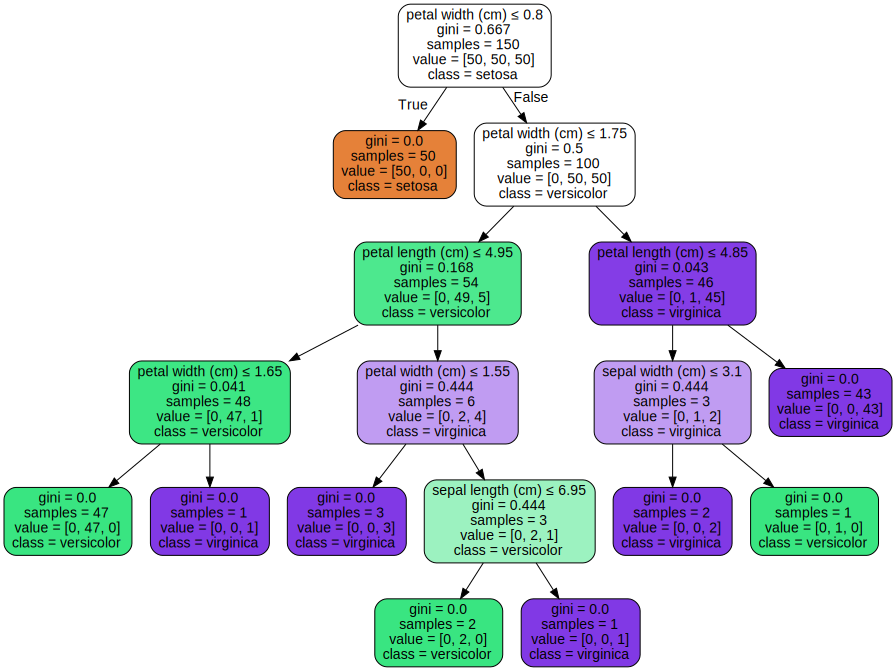

In [ ]:
X, y = load_iris(return_X_y=True)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)
iris = load_iris()
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

做了 Gradient Boost 的 Decision Tree

有很多 decision tree (在 loss 是 MSE 的情況下)

Tree 1：得到預測值1

Tree 2：訓練時用 答案-預測值1 當 label，得到預測值2

Tree 3：訓練時用 答案-(預測值1+預測值2) 當 label，得到預測值3

......

最後：預測值1 + 預測值2 + 預測值3 + ... 為最終答案

介紹：[GBDT](https://machine-learning-notes.gitlab.io/docs/supervised_learning/gbdt/) [Decision Tree](https://machine-learning-notes.gitlab.io/docs/supervised_learning/decision_tree/)


In [ ]:
def get_feature_label_baseline2(df):
    df = df.copy()
    x_mean = df['x'].mean()
    y_mean = df['x'].mean()
    df['x'].fillna(x_mean, inplace=True)
    df['y'].fillna(y_mean, inplace=True)
    df.fillna(0, inplace=True)
    cols = [
        'x', 'y', 'construction to complete the years',
        'Building present situation pattern - room', 
        'building present situation pattern - hall',
        'the berth total price NTD',
    ]
    return df[cols].values, df['price'].values, cols


train_feature, train_label, columns = get_feature_label_baseline2(df_train)
val_feature, val_label, _ = get_feature_label_baseline2(df_val)
test_feature, test_label, _ = get_feature_label_baseline2(df_test)
print('shapes', train_feature.shape, val_feature.shape, test_feature.shape)

best_model = None
best_brmse = np.inf
for k in [3, 5, 7, 9, 11, 13]:
    knn = KNeighborsRegressor(n_neighbors=k)
    scaler = MinMaxScaler()
    feature = scaler.fit_transform(train_feature)
    knn.fit(feature, train_label)
    val_pred = knn.predict(scaler.transform(val_feature))
    print('neighbors = %d KNN val rmse, biased rmse' % k, biased_rmse(val_label, val_pred))
    _, brmse = biased_rmse(val_label, val_pred)
    if brmse < best_brmse:
        best_brmse = brmse
        best_model = knn

train_pred = best_model.predict(feature)
val_pred = best_model.predict(scaler.transform(val_feature))
test_pred = best_model.predict(scaler.transform(test_feature))
print('KNN train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('KNN val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('KNN test rmse, biased rmse', biased_rmse(test_label, test_pred))
knn_rmse, knn_brmse = biased_rmse(test_label, test_pred)

best_model = None
best_brmse = np.inf
for d in [4, 6, 8, 10, 15, 20, None]:
    model = LGBMRegressor(max_depth=d, seed=0)
    model.fit(train_feature, train_label)
    val_pred = model.predict(val_feature)
    print('max_depth = %s LGBM val rmse, biased rmse' % str(d), biased_rmse(val_label, val_pred))
    _, brmse = biased_rmse(val_label, val_pred)
    if brmse < best_brmse:
        best_brmse = brmse
        best_model = model

train_pred = best_model.predict(train_feature)
val_pred = best_model.predict(val_feature)    
test_pred = best_model.predict(test_feature)
train_rmse, train_brmse = biased_rmse(train_label, train_pred)
print('LGBM train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('LGBM val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('LGBM test rmse, biased rmse', biased_rmse(test_label, test_pred))
lgbm_rmse, lgbm_brmse = biased_rmse(test_label, test_pred)
print(list(zip(columns, best_model.feature_importances_)))

print('LightGBM improve rmse %.2f brmse %.2f' % (knn_rmse - lgbm_rmse, knn_brmse - lgbm_brmse))


shapes (6142, 6) (171, 6) (2163, 6)
neighbors = 3 KNN val rmse, biased rmse (105099.69396381013, 128352.0242046009)
neighbors = 5 KNN val rmse, biased rmse (111312.21317011658, 125630.94989140086)
neighbors = 7 KNN val rmse, biased rmse (118703.5518697707, 130452.641634784)
neighbors = 9 KNN val rmse, biased rmse (109343.96761298465, 125802.67449597539)
neighbors = 11 KNN val rmse, biased rmse (108553.94310827342, 124493.93292825636)
neighbors = 13 KNN val rmse, biased rmse (109994.25172231472, 124810.80821395293)
KNN train rmse, biased rmse (74854.21970038315, 87040.90851087349)
KNN val rmse, biased rmse (108553.94310827342, 124493.93292825636)
KNN test rmse, biased rmse (100369.97171755054, 111067.50622715637)
max_depth = 4 LGBM val rmse, biased rmse (103469.68631076896, 121092.23898416857)
max_depth = 6 LGBM val rmse, biased rmse (102838.10139479565, 117937.22548421835)
max_depth = 8 LGBM val rmse, biased rmse (101302.83447473706, 116870.16148036023)
max_depth = 10 LGBM val rmse, bi

**為 Biased RMSE 特化的模型？**

LightGBM 預設優化 MSE ，可以傳入 objective=Python callable 使用自定義的目標函數

Customized objective function. Should accept two parameters: preds, train_data, and return (grad, hess).

In [ ]:
def obj_biased_mse(y_true, y_pred):
    gt = np.where(y_true <= y_pred)[0]
    lt = np.where(y_true > y_pred)[0]
    grad = np.zeros_like(y_true)
    hess = np.zeros_like(y_true)
    # 2 * (y_pred - y_true)^2 對 y_pred 微分
    grad[gt] = (y_pred[gt] - y_true[gt]) * 4
    grad[lt] = (y_pred[lt] - y_true[lt]) * 2
    # (y_pred - y_true)^2 對 y_pred 二次微分
    hess[gt] = 4
    hess[lt] = 2
    return grad, hess

best_model = None
best_brmse = np.inf
for d in [4, 6, 8, 10, 15, 20, None]:
    model = LGBMRegressor(max_depth=d, objective=obj_biased_mse, seed=0)
    model.fit(train_feature, train_label)
    val_pred = model.predict(val_feature)
    print('max_depth = %s LGBM val rmse, biased rmse' % str(d), biased_rmse(val_label, val_pred))
    _, brmse = biased_rmse(val_label, val_pred)
    if brmse < best_brmse:
        best_brmse = brmse
        best_model = model

train_pred = best_model.predict(train_feature)
val_pred = best_model.predict(val_feature)    
test_pred = best_model.predict(test_feature)
train_rmse_cus, train_brmse_cus = biased_rmse(train_label, train_pred)
print('LGBM train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('LGBM val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('LGBM test rmse, biased rmse', biased_rmse(test_label, test_pred))
print('Custom loss improve training rmse %.2f brmse %.2f' % (train_rmse - train_rmse_cus, train_brmse - train_brmse_cus))

max_depth = 4 LGBM val rmse, biased rmse (109090.84362318502, 116863.70051197482)
max_depth = 6 LGBM val rmse, biased rmse (103013.22937020265, 114550.6831205055)
max_depth = 8 LGBM val rmse, biased rmse (103461.47526982853, 115525.95412687701)
max_depth = 10 LGBM val rmse, biased rmse (102572.19456814938, 115591.22480829147)
max_depth = 15 LGBM val rmse, biased rmse (102694.3904494573, 116632.43107417112)
max_depth = 20 LGBM val rmse, biased rmse (101664.44645867437, 116067.17629128271)
max_depth = None LGBM val rmse, biased rmse (101664.44645867437, 116067.17629128271)
LGBM train rmse, biased rmse (67890.55260737843, 73429.46754254212)
LGBM val rmse, biased rmse (103013.22937020265, 114550.6831205055)
LGBM test rmse, biased rmse (99310.7994613543, 104115.23938129035)
Custom loss improve training rmse -4339.83 brmse 248.07


**KNN 換成 LightGBM => 5750 / 8780 improve**

如何再進步？
# **特徵工程 (feature engineering)**

特徵工程：嘗試不同的特徵或是用不同的方式表示特徵

常見的處理方式：

1. Missing value 做不同的處理
1. Outlier 做不同的處理

Numerical features:
1. 改變數值範圍 (min max scaler, z score standardization)
1. 取 log
1. 切 bin, ex. (-inf, 1) => 0, [1, 10) => 1, [10, 104) => 2, ...
1. 兩項以上組合 ex. 新 feature 車位單價 = 車位總價 / 車位面積

Categorical features:
1. One hot encoding. [[a], [b], [c]] 變成 [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
1. Multi hot encoding. [[a, b], [a], [a, b, c]] 變成 [[1, 1, 0], [1, 0, 0], [1, 1, 1]]
1. Label encoding. [[a], [b], [c]] 變成 [[0], [1], [2]]. 注意：decision-based model only (為什麼？)
1. Bin counting. 值使用該特徵值出現次數/比例/rank [[a], [b], [b]] 變成 [[1], [2], [2]]
1. 兩項以上的組合 ex. 把兩個 column 合併成 tuple 當作新的 categorical feature [[a, a], [a, b], [c, z]] 變成 [[axa], [axb], [cxz]]


# **特徵選擇 (feature selection)**

https://scikit-learn.org/stable/modules/feature_selection.html

1. 基於統計的方法
  1. 計算 feature 間的相關性 ex. correlation coefficient，刪掉相關性高的
  1. 計算 feature 與 label 的相關性 ex. correlation coefficient，保留相關性高的
1. 基於模型的方法
  1. 訓練完模型後，刪掉重要性低的(ie. 對模型預測值影響不大的)
1. 基於驗證集的方法
  1. 逐一加入(或刪除) feature，觀察 validation score 的變化

In [ ]:
df_train['section'] = df_train['address'].map(lambda x: x[:6] if x[5] == '區' else '')
df_val['section'] = df_val['address'].map(lambda x: x[:6] if x[5] == '區' else '')
df_test['section'] = df_test['address'].map(lambda x: x[:6] if x[5] == '區' else '')
sections = df_train['section'].unique()
levels = df_train['shifting level'].unique()

def get_feature_label(df):
    df = df.copy()
    x_mean = df['x'].mean()
    y_mean = df['x'].mean()
    df['x'].fillna(x_mean, inplace=True)
    df['y'].fillna(y_mean, inplace=True)
    df.fillna(0, inplace=True)

    df['construction to complete the years'] = df['construction to complete the years'].map(lambda x: arrow.get(str(int(x) + 19110000), 'YYYYMMDD').timestamp // 86400 if x != 0 else np.nan)
    y_mean = df['construction to complete the years'].mean()
    df['construction to complete the years'].fillna(y_mean, inplace=True)

    cols = [
        'x', 'y', 'construction to complete the years',
        'building present situation pattern - hall', 
        'the berth total price NTD',
    ]
    
    # multi-hot encoding
    for note in note_list:
        df['note_%s' % note] = df['the note'].map(lambda x: note in str(x))
        cols.append('note_%s' % note)

    # one-hot encoding
    for section in sections:
        df['section_%s' % section] = (df['section'] == section).astype(int)
        cols.append('section_%s' % section)
    
    return df[cols].values, df['price'].values, cols

train_feature, train_label, columns = get_feature_label(df_train)
val_feature, val_label, _ = get_feature_label(df_val)
test_feature, test_label, _ = get_feature_label(df_test)
print('shapes', train_feature.shape, val_feature.shape, test_feature.shape)

best_model = None
best_brmse = np.inf
for d in [4, 6, 8, 10, 15, 20, None]:
    model = LGBMRegressor(max_depth=d, seed=0)
    model.fit(train_feature, train_label)
    val_pred = model.predict(val_feature)
    print('max_depth = %s LGBM val rmse, biased rmse' % str(d), biased_rmse(val_label, val_pred))
    _, brmse = biased_rmse(val_label, val_pred)
    if brmse < best_brmse:
        best_brmse = brmse
        best_model = model

train_pred = best_model.predict(train_feature)
val_pred = best_model.predict(val_feature)    
test_pred = best_model.predict(test_feature)
print('LGBM train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('LGBM val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('LGBM test rmse, biased rmse', biased_rmse(test_label, test_pred))
lgbm_rmse, lgbm_brmse = biased_rmse(test_label, test_pred)
print(list(zip(columns, best_model.feature_importances_)))

print('LightGBM improve rmse %.2f brmse %.2f' % (knn_rmse - lgbm_rmse, knn_brmse - lgbm_brmse))

shapes (6142, 30) (171, 30) (2163, 30)
max_depth = 4 LGBM val rmse, biased rmse (100835.7612098528, 110069.121219074)
max_depth = 6 LGBM val rmse, biased rmse (97176.1997516706, 107395.0431991002)
max_depth = 8 LGBM val rmse, biased rmse (97482.4022080259, 107584.09427237307)
max_depth = 10 LGBM val rmse, biased rmse (96850.41753302405, 107028.1015822433)
max_depth = 15 LGBM val rmse, biased rmse (97704.65545883945, 106953.036159939)
max_depth = 20 LGBM val rmse, biased rmse (97327.615417309, 106438.53109391007)
max_depth = None LGBM val rmse, biased rmse (97327.615417309, 106438.53109391007)
LGBM train rmse, biased rmse (61860.741482340105, 70662.46501193552)
LGBM val rmse, biased rmse (97327.615417309, 106438.53109391007)
LGBM test rmse, biased rmse (90575.93356668125, 97033.1879945229)
[('x', 719), ('y', 742), ('construction to complete the years', 727), ('building present situation pattern - hall', 182), ('the berth total price NTD', 151), ('note_親友、員工或其他特殊關係間之交易', 86), ('note_含增建或

In [ ]:
best_model = None
best_brmse = np.inf
scaler = MinMaxScaler()
feature = scaler.fit_transform(train_feature)
for k in [3, 5, 7, 9, 11, 13]:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(feature, train_label)
    val_pred = knn.predict(scaler.transform(val_feature))
    print('neighbors = %d KNN val rmse, biased rmse' % k, biased_rmse(val_label, val_pred))
    _, brmse = biased_rmse(val_label, val_pred)
    if brmse < best_brmse:
        best_brmse = brmse
        best_model = knn

train_pred = best_model.predict(feature)
val_pred = best_model.predict(scaler.transform(val_feature))
test_pred = best_model.predict(scaler.transform(test_feature))
print('KNN train rmse, biased rmse', biased_rmse(train_label, train_pred))
print('KNN val rmse, biased rmse', biased_rmse(val_label, val_pred))
print('KNN test rmse, biased rmse', biased_rmse(test_label, test_pred))
knn2_rmse, knn2_brmse = biased_rmse(test_label, test_pred)

print('KNN improved by feature rmse %.2f brmse %.2f' % (knn_rmse - knn2_rmse, knn_brmse - knn2_brmse))

neighbors = 3 KNN val rmse, biased rmse (116704.3020372289, 128403.40130926)
neighbors = 5 KNN val rmse, biased rmse (109570.06438438327, 119909.97011683341)
neighbors = 7 KNN val rmse, biased rmse (108018.78363161534, 116373.2163105461)
neighbors = 9 KNN val rmse, biased rmse (97220.04601228524, 108862.65982877738)
neighbors = 11 KNN val rmse, biased rmse (99465.96796904744, 109989.21090642718)
neighbors = 13 KNN val rmse, biased rmse (97844.71911457842, 108956.41708414555)
KNN train rmse, biased rmse (69847.75453344651, 78948.55183534873)
KNN val rmse, biased rmse (97220.04601228524, 108862.65982877738)
KNN test rmse, biased rmse (94294.94879944001, 100448.8393159541)
KNN improved by feature rmse 6075.02 brmse 10618.67


Feature improve: 6075 / 10618

Model improve: 5750 / 8730

Feature > Model ，而好的 feature 來自 domain knowledge 以及對資料的分析、觀察

注意 feature 維度相對於資料筆數不可以太大 (為什麼？)